# Pre-processing

## Cleaning

Repeating the process defined in the notebook 0_eda.ipynb:
* dropping duplicates
* dropping rows with missing matches+player_level+login_type (1.8% of the dataset)
* imputing missing number of matches as 0 (assuming new player)

In [1]:
# auxiliary functions for plotting and for computing model performance per quantile
from utils_plotting import *
from utils_quantilefunctions import *

In [2]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import pandas as pd
df = pd.read_csv('ds201608.csv')

In [5]:
ordinal = ['sessions_length', 'sessions', 'retained_days', 'matches', 'player_level']
nominal = ['platform', 'country', 'login_type', 'is_payer']
nominal_= ['platform', 'country', 'login_type']
target = 'is_payer'

In [6]:
%%time
for col in nominal:
    df[col] = df[col].astype('category')

Wall time: 13 ms


In [7]:
df = df.drop_duplicates()

In [8]:
# assumption#1 - if neither of the values matches, player_level, login_type is known, then these are unknown
# assumption#2 - if all values are known except the number of matches, then this is 0

# dropping rows with all 3 values missing
df = df.dropna(subset=['matches', 'player_level', 'login_type'])

# imputing missing number of matches as 0 in the remaining records
df['matches'] = df['matches'].fillna(0)

## Train-test splitting

* 90% of the dataset for crossval, 10% for testing.
* The split is stratified by the target is_player
* Since we're using apriori knowledge for building the test set, this is actually more of a validation set.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X, X_test, y, y_test = train_test_split(df.drop(target, axis=1), df[target],
                                        stratify=df[target], test_size=0.10, random_state=1234)

df_trainval = pd.concat([X,y],axis=1)
df_test = pd.concat([X_test,y_test],axis=1)

y = y.astype(int)
y_test = y_test.astype(int)

## Preparing data for training - encoding cats

* For simplicity, all categoricals are encoded in bits.
* The country is encoded using 8 bits, which would allow representing up to 256 countries (2^8).

In [11]:
import category_encoders as ce

In [12]:
# instantiate an encoder - here we use Binary()
ce_binary = ce.BinaryEncoder(cols = nominal_)

# fit and transform and presto, you've got encoded data
X_enc      = ce_binary.fit_transform(X)
X_test_enc = ce_binary.fit_transform(X_test)

## Prepare data for training - scaling

* Because we'll be training logistic regression classifiers, the ordinal features must be re-scaled.
* We'll compare standard scaling (based on population mean and standard deviation) and min-max scaling.

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [14]:
%%time

# Standard scaling 
scaler = {}
X_enc_scaled      = X_enc.copy()
X_test_enc_scaled = X_test_enc.copy()

for col in ordinal:
    scaler[col] = StandardScaler().fit(X_enc[col].values.reshape(-1, 1))
    X_enc_scaled[col]      = scaler[col].transform(X_enc_scaled[col].values.reshape(-1, 1))      # Training set
    X_test_enc_scaled[col] = scaler[col].transform(X_test_enc_scaled[col].values.reshape(-1, 1)) # Test set

Wall time: 33 ms


In [15]:
%%time

# Min-max scaling
minmax_scaler = {}
X_enc_minmax_scaled = X_enc.copy()
X_test_enc_minmax_scaled = X_test_enc.copy()

for col in ordinal:
    minmax_scaler[col] = MinMaxScaler().fit(X_enc[col].values.reshape(-1, 1))
    X_enc_minmax_scaled[col]      = minmax_scaler[col].transform(X_enc_minmax_scaled[col].values.reshape(-1, 1))
    X_test_enc_minmax_scaled[col] = minmax_scaler[col].transform(X_test_enc_minmax_scaled[col].values.reshape(-1, 1))

Wall time: 31 ms


In [16]:
X_sets      = [X_enc_scaled,      X_enc_minmax_scaled,      X_enc]
X_test_sets = [X_test_enc_scaled, X_test_enc_minmax_scaled, X_test_enc]

# Modeling based on the original features

## Training

Models trained:
* Logistic regression with standard scaled features
* Logistic regression with min-max scaled features
* Random forest

In [17]:
%%time
lgrParams = {'C': [0.5, 0.475, 0.45], 'penalty': ['l1', 'l2']}

# Standard scaling
gridSearchLgr = GridSearchCV(estimator=LogisticRegression(solver='liblinear'), cv=3,
                             param_grid=lgrParams,scoring='roc_auc').fit(X_enc_scaled, y)

Wall time: 16.5 s


In [18]:
%%time
lgrParams = {'C': [10000, 5000, 1000], 'penalty': ['l1', 'l2']}

# Min-max scaling
gridSearchLgr_minmax = GridSearchCV(estimator=LogisticRegression(solver='liblinear'), cv=3,
                             param_grid=lgrParams,scoring='roc_auc').fit(X_enc_minmax_scaled, y)

Wall time: 8.46 s


In [19]:
%%time
rfParams = {'max_depth': [11, 13, 15], 'n_estimators': [150, 165, 180]}
gridSearchRF = GridSearchCV(estimator=RandomForestClassifier(), cv=3, 
                             param_grid=rfParams, scoring='roc_auc').fit(X_enc, y)

Wall time: 1min 35s


In [20]:
print('%10s' % 'C: ', gridSearchLgr.best_estimator_.C)
print('%10s' % 'Penalty:', gridSearchLgr.best_estimator_.penalty)

       C:  0.475
  Penalty: l1


In [21]:
print('%10s' % 'C: ', gridSearchLgr_minmax.best_estimator_.C)
print('%10s' % 'Penalty:', gridSearchLgr_minmax.best_estimator_.penalty)

       C:  1000
  Penalty: l1


In [22]:
print('%10s' % 'Max_depth: ', gridSearchRF.best_estimator_.max_depth)
print('%10s' % 'Estimators:', gridSearchRF.best_estimator_.n_estimators)

Max_depth:  13
Estimators: 180


In [23]:
models = [gridSearchLgr, gridSearchLgr_minmax, gridSearchRF]
model_names = ['Lgr std-scaled', 'Lgr minmax-scaled', 'Random forest']

## AUC values

Random forest classifier:
* visibly better than the logreg classifiers in the training set.
* its performance in the test set drops considerably (overfitting).

Logistic regression classifiers:
* The two alternative feature scaling approaches produce similar results.
* The performance of these models is similar in the training and in the test sets.

In [24]:
print('Training set AUCs:')
plot_model_aucs(models, model_names, X_sets, y, num_format='%.3f')

Training set AUCs:
      Lgr std-scaled 0.850
   Lgr minmax-scaled 0.850
       Random forest 0.937


In [25]:
print('Test set AUCs:')
plot_model_aucs(models, model_names, X_test_sets, y_test, num_format='%.3f')

Test set AUCs:
      Lgr std-scaled 0.856
   Lgr minmax-scaled 0.856
       Random forest 0.877


## Confusion matrix

* On the training set, the random forest classifier has less false positives than false negatives, while the logreg classifiers have +2-times more false negatives than false positives.
* On the test set, the random forest classifier has more false positives than the logreg models but still fewer false negatives.
* This shows that the performance decay of the random forest classifier is mostly due to the positive class - even though this is the minority class.

In [26]:
models = [gridSearchLgr, gridSearchLgr_minmax, gridSearchRF]
X_sets = [X_enc_scaled, X_enc_minmax_scaled, X_enc]

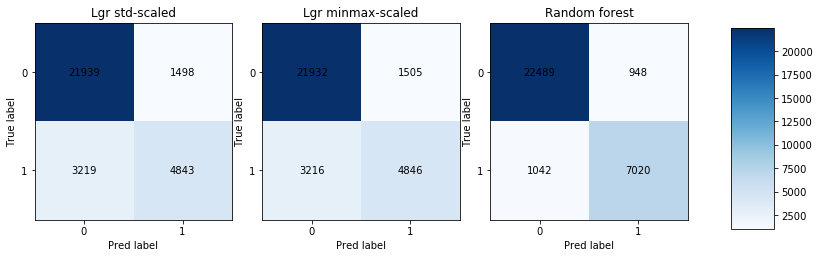

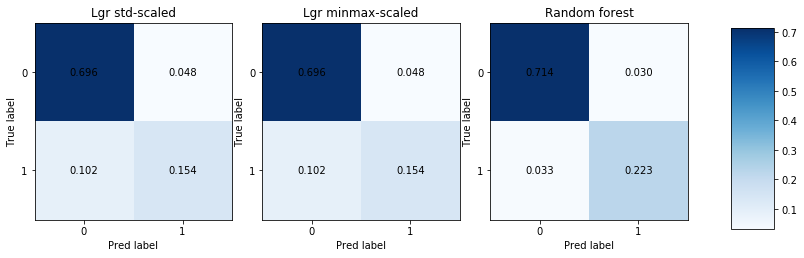

In [27]:
cm = compute_and_plot_cm(models, model_names, X_sets, y, normalize=False, format='%d')
_  = compute_and_plot_cm(models, model_names, X_sets, y, normalize=True, format='%.3f')

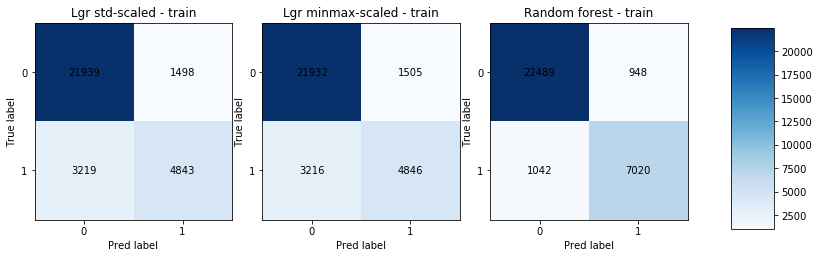

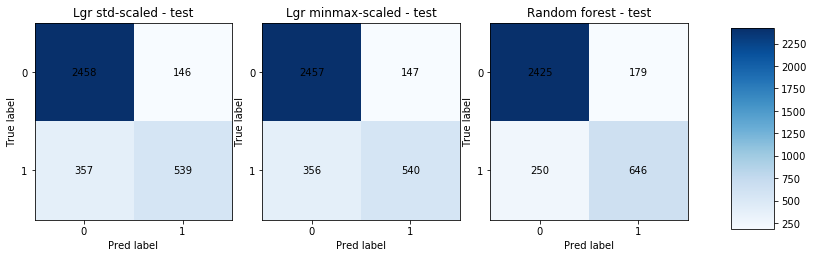

In [28]:
_  = compute_and_plot_cm(models, [model + ' - train' for model in model_names], X_sets, y, normalize=False, format='%d')
_  = compute_and_plot_cm(models, [model + ' - test'  for model in model_names], X_test_sets, y_test, normalize=False, format='%d')

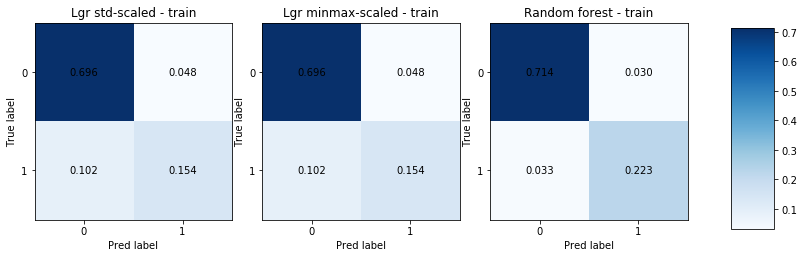

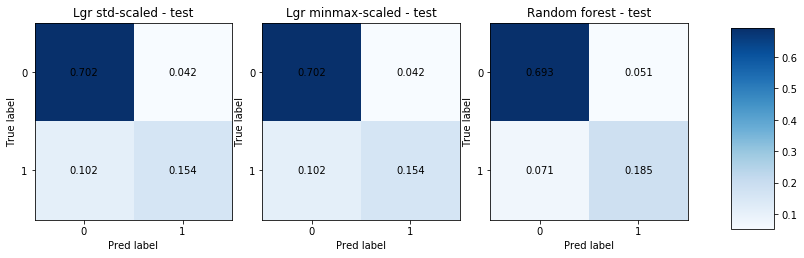

In [29]:
_  = compute_and_plot_cm(models, [model + ' - train' for model in model_names], X_sets, y, normalize=True, format='%.3f')
_  = compute_and_plot_cm(models, [model + ' - test'  for model in model_names], X_test_sets, y_test, normalize=True, format='%.3f')

## ROC curves

* the performance of the logreg models is nearly constant between the training and test sets.
* the performance of the random forest classifier shows a strong decay in the test set.
* nevertheless, the random forest classifier seems superior in both datasets.

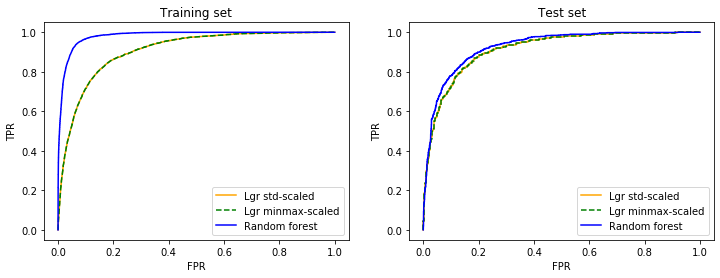

In [30]:
colors = ['orange', 'green', 'blue']
linestyles = ['solid', 'dashed', 'solid']

fig, axs = plt.subplots(1,2, figsize=(12,4))
fpr,      tpr,      thresholds      = compute_and_plot_rocs(models, X_sets,      y,      colors, linestyles, axs[0], legend=model_names, title='Training set')
fpr_test, tpr_test, thresholds_test = compute_and_plot_rocs(models, X_test_sets, y_test, colors, linestyles, axs[1], legend=model_names, title='Test set')

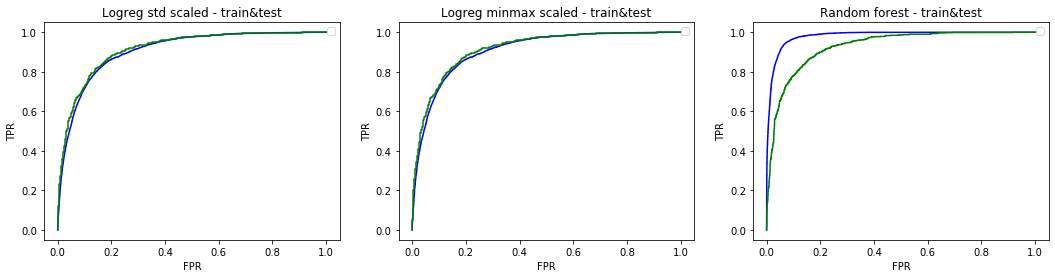

In [31]:
# note: seaborn lineplot is extremely slow, so better use matplotlib.pyplot.plot

fig, axs = plt.subplots(1, 3, figsize=(18,4))

_,_,_ = compute_and_plot_rocs([models[0]], [X_sets[0]],      y,      ['blue'], ['solid'], axs[0], legend='', title='Logreg std scaled - train&test')
_,_,_ = compute_and_plot_rocs([models[0]], [X_test_sets[0]], y_test, ['green'], ['solid'], axs[0], legend='', title='Logreg std scaled - train&test')

_,_,_ = compute_and_plot_rocs([models[1]], [X_sets[1]],      y,      ['blue'], ['solid'], axs[1], legend='', title='Logreg minmax scaled - train&test')
_,_,_ = compute_and_plot_rocs([models[1]], [X_test_sets[1]], y_test, ['green'], ['solid'], axs[1], legend='', title='Logreg minmax scaled - train&test')

_,_,_ = compute_and_plot_rocs([models[2]], [X_sets[2]],      y,      ['blue'], ['solid'], axs[2], legend='', title='Random forest - train&test')
_,_,_ = compute_and_plot_rocs([models[2]], [X_test_sets[2]], y_test, ['green'], ['solid'], axs[2], legend='', title='Random forest - train&test')

## Quantile evaluation

* Percentiles in the test set have very few records. It is thus preferable to look at decile metrics.
* The random forest classifier is only slightly more precise than the logreg models in the 10th decile of the test set - 89% to 88% precision.
* The random forest model classifies 3.5 times more true positives in the 10th decile compared to random classification (lift). 

In [32]:
percentiles = index_for_percentiles(array_length = len(X_enc), num_splits = 100)
deciles     = index_for_percentiles(array_length = len(X_enc), num_splits = 10)

In [33]:
%%time
percentile_metrics = {}
decile_metrics = {}

for idx, (model, X) in enumerate(zip(models,X_sets)):
    y_prob = model.best_estimator_.predict_proba(X)[:,1]
    percentile_metrics[idx] = quantile_metrics(y_true = y, y_prob=y_prob, quantile_idxs=percentiles)
    decile_metrics[idx]     = quantile_metrics(y_true = y, y_prob=y_prob, quantile_idxs=deciles)

Wall time: 1.3 s


In [34]:
test_percentiles = index_for_percentiles(array_length = len(X_test_enc), num_splits = 100)
test_deciles     = index_for_percentiles(array_length = len(X_test_enc), num_splits = 10)

In [35]:
%%time
test_percentile_metrics = {}
test_decile_metrics = {}

for idx, (model, X) in enumerate(zip(models,X_test_sets)):
    y_prob = model.best_estimator_.predict_proba(X)[:,1]
    test_percentile_metrics[idx] = quantile_metrics(y_true = y_test, y_prob=y_prob, quantile_idxs=test_percentiles)
    test_decile_metrics[idx]     = quantile_metrics(y_true = y_test, y_prob=y_prob, quantile_idxs=test_deciles)

Wall time: 270 ms


In [36]:
compare_model_quantile_metrics(percentile_metrics, model_names, 1)

,quantile,n,tp,lift,precision,max_lift
Lgr std-scaled,100.0,315,292,3.621930,0.926984,3.907219
Lgr minmax-scaled,100.0,315,292,3.621930,0.926984,3.907219
Random forest,100.0,315,315,3.907219,1.000000,3.907219


In [37]:
compare_model_quantile_metrics(test_percentile_metrics, model_names, 1)

,quantile,n,tp,lift,precision,max_lift
Lgr std-scaled,100.0,35,34,3.794643,0.971429,3.90625
Lgr minmax-scaled,100.0,35,34,3.794643,0.971429,3.90625
Random forest,100.0,35,33,3.683036,0.942857,3.90625


In [38]:
compare_model_quantile_metrics(decile_metrics, model_names, 1)

,quantile,n,tp,lift,precision,max_lift
Lgr std-scaled,10.0,3150,2683,3.327958,0.851746,3.907219
Lgr minmax-scaled,10.0,3150,2685,3.330439,0.852381,3.907219
Random forest,10.0,3150,3106,3.852642,0.986032,3.907219


In [39]:
compare_model_quantile_metrics(test_decile_metrics, model_names, 1)

,quantile,n,tp,lift,precision,max_lift
Lgr std-scaled,10.0,350,308,3.437500,0.880000,3.90625
Lgr minmax-scaled,10.0,350,309,3.448661,0.882857,3.90625
Random forest,10.0,350,313,3.493304,0.894286,3.90625


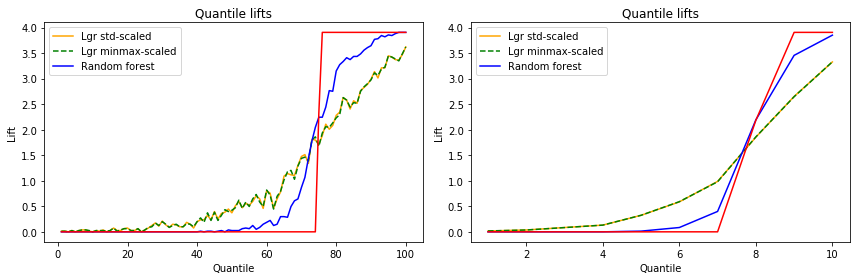

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
lift_plotting(percentile_metrics, colors, linestyles, model_names, axs[0])
lift_plotting(decile_metrics, colors, linestyles, model_names, axs[1])

plt.tight_layout()

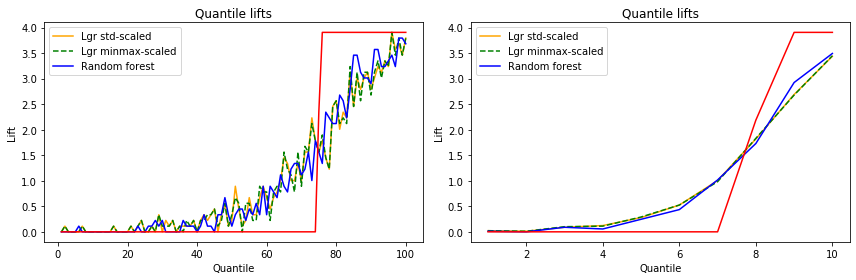

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
lift_plotting(test_percentile_metrics, colors, linestyles, model_names, axs[0])
lift_plotting(test_decile_metrics, colors, linestyles, model_names, axs[1])

plt.tight_layout()

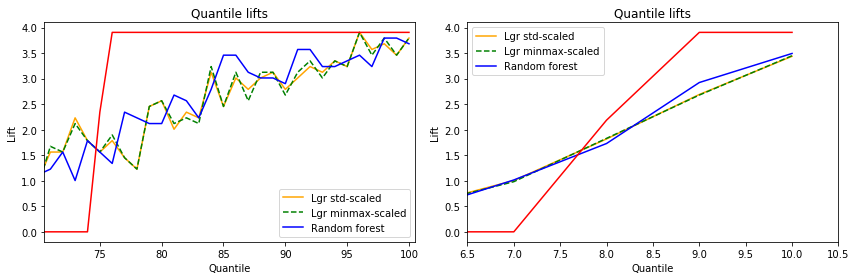

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
lift_plotting(test_percentile_metrics, colors, linestyles, model_names, axs[0])
lift_plotting(test_decile_metrics, colors, linestyles, model_names, axs[1])

axs[0].set_xlim([70.5, 100.5])
axs[1].set_xlim([6.5, 10.5])
plt.tight_layout()

# Adding new features

Ideas for new features (these are all possible combinations of the 5 ordinal features):

* avg_session_length_per_session = session_length / sessions
* avg_session_length_per_day     = session_length / retained_days
* avg_session_length_per_match   = session_length / matches
* avg_session_length_per_level   = session_length / player_level

* avg_levelupgrade_per_session = player_level / sessions
* avg_levelupgrade_per_day     = player_level / retained_days
* avg_levelupgrade_per_match   = player_level / matches

* avg_matches_per_session = matches / sessions
* avg_matches_per_day     = matches / retained_days

* avg_sessions_per_day    = sessions / retained_days

In [43]:
def add_features(X):
    X['avg_session_length_per_session'] = X['sessions_length'] / X['sessions']
    X['avg_session_length_per_day']     = X['sessions_length'] / X['retained_days']
    X['avg_session_length_per_match']   = X['sessions_length'] / X['matches']
    X['avg_session_length_per_level']   = X['sessions_length'] / X['player_level']
    X['avg_levelupgrade_per_session']   = X['player_level'] / X['sessions']
    X['avg_levelupgrade_per_day']       = X['player_level'] / X['retained_days']
    X['avg_levelupgrade_per_match']     = X['player_level'] / X['matches']
    X['avg_matches_per_session']        = X['matches'] / X['sessions']
    X['avg_matches_per_day']            = X['matches'] / X['retained_days']
    X['avg_sessions_per_day']           = X['sessions'] / X['retained_days']
    
    return X

In [44]:
X_enc_plus        = add_features(X_enc.copy())
X_enc_scaled_plus = add_features(X_enc_scaled.copy())

Some of these features may take inf values for new players, having 0 matches/sessions/retained_days. In these cases, the new features will be imputed with 0.

In [45]:
X_enc_plus = X_enc_plus.replace([np.inf, -np.inf], np.nan)
X_enc_plus = X_enc_plus.replace(np.nan, 0)

X_enc_scaled_plus = X_enc_scaled_plus.replace([np.inf, -np.inf], np.nan)
X_enc_scaled_plus = X_enc_scaled_plus.replace(np.nan, 0)

In [46]:
X_sets_plus = [X_enc_scaled_plus, X_enc_plus]

In [47]:
X_enc_test_plus        = add_features(X_test_enc.copy())
X_enc_test_scaled_plus = add_features(X_test_enc_scaled.copy())

In [48]:
X_enc_test_plus = X_enc_test_plus.replace([np.inf, -np.inf], np.nan)
X_enc_test_plus = X_enc_test_plus.replace(np.nan, 0)

X_enc_test_scaled_plus = X_enc_test_scaled_plus.replace([np.inf, -np.inf], np.nan)
X_enc_test_scaled_plus = X_enc_test_scaled_plus.replace(np.nan, 0)

In [49]:
X_test_sets_plus = [X_enc_test_scaled_plus, X_enc_test_plus]

## Training

In [50]:
%%time
lgrParams = {'C': [.5, 0.45, 0.4], 'penalty': ['l1', 'l2']}

# Standard scaling
gridSearchLgr_plus = GridSearchCV(estimator=LogisticRegression(solver='liblinear'), cv=3,
                             param_grid=lgrParams,scoring='roc_auc').fit(X_enc_scaled_plus, y)

Wall time: 28.5 s


In [51]:
%%time
rfParams = {'max_depth': [10, 11, 12], 'n_estimators': [135, 150, 165]}
gridSearchRF_plus = GridSearchCV(estimator=RandomForestClassifier(), cv=3, 
                             param_grid=rfParams, scoring='roc_auc').fit(X_enc_plus, y)

Wall time: 2min 33s


In [52]:
print('%10s' % 'C: ', gridSearchLgr_plus.best_estimator_.C)
print('%10s' % 'Penalty:', gridSearchLgr_plus.best_estimator_.penalty)

       C:  0.45
  Penalty: l1


In [53]:
print('%10s' % 'Max_depth: ', gridSearchRF_plus.best_estimator_.max_depth)
print('%10s' % 'Estimators:', gridSearchRF_plus.best_estimator_.n_estimators)

Max_depth:  12
Estimators: 165


In [54]:
models_plus = [gridSearchLgr_plus, gridSearchRF_plus]
model_names_plus = [model_names[0], model_names[2]]

## AUC values

* There's not much change in AUC by using the new features.
* The logreg model gets a small improvement while the random forest performance decays.
* Again, the performance of the logreg is constant in the training and test sets while that of the random forest classifier decays in the test set.

In [55]:
print('Training set AUCs with new features:')
plot_model_aucs(models_plus, model_names_plus, X_sets_plus, y, num_format='%.3f')

print('')

print('Training set AUCs with original features:')
plot_model_aucs(models, model_names, X_sets, y, num_format='%.3f')

Training set AUCs with new features:
      Lgr std-scaled 0.851
       Random forest 0.934

Training set AUCs with original features:
      Lgr std-scaled 0.850
   Lgr minmax-scaled 0.850
       Random forest 0.937


In [56]:
print('Test set AUCs:')
plot_model_aucs(models_plus, model_names_plus, X_test_sets_plus, y_test, num_format='%.3f')

print('')

print('Training set AUCs with original features:')
plot_model_aucs(models, model_names, X_test_sets, y_test, num_format='%.3f')

Test set AUCs:
      Lgr std-scaled 0.858
       Random forest 0.875

Training set AUCs with original features:
      Lgr std-scaled 0.856
   Lgr minmax-scaled 0.856
       Random forest 0.877


## Confusion matrix

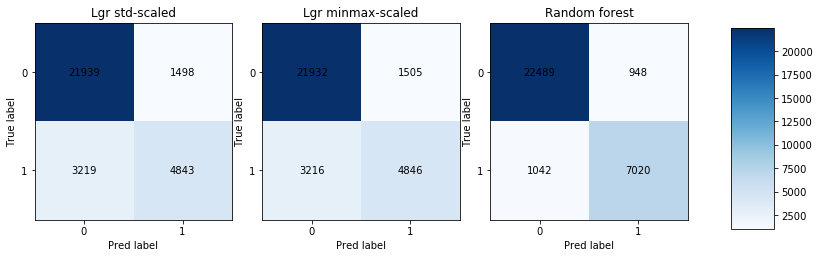

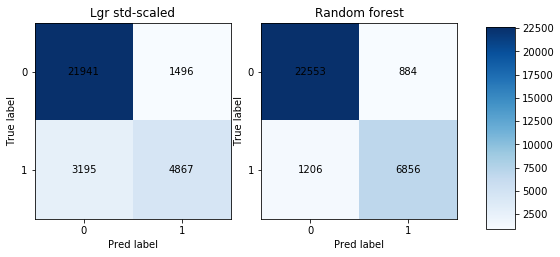

In [57]:
cm       = compute_and_plot_cm(models,      model_names, X_sets,      y, normalize=False, format='%d')
cm_plus  = compute_and_plot_cm(models_plus, model_names_plus, X_sets_plus, y, normalize=False, format='%d')

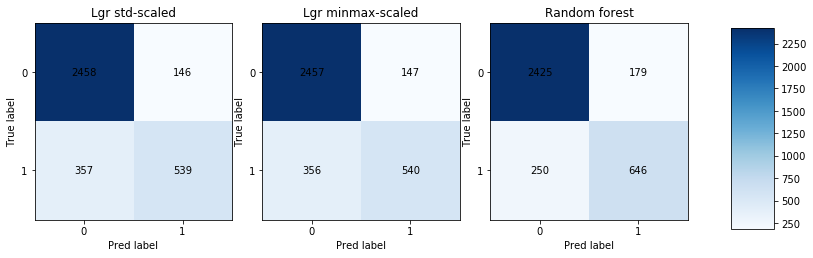

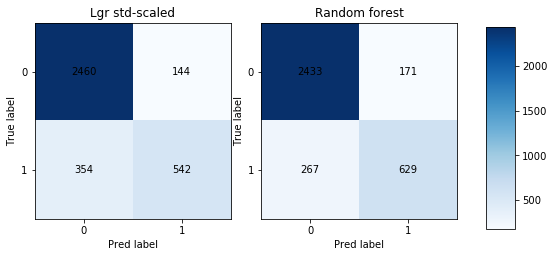

In [58]:
cm_test       = compute_and_plot_cm(models,      model_names, X_test_sets,      y_test, normalize=False, format='%d')
cm_test_plus  = compute_and_plot_cm(models_plus, model_names_plus, X_test_sets_plus, y_test, normalize=False, format='%d')

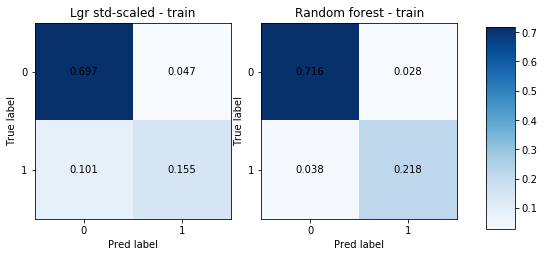

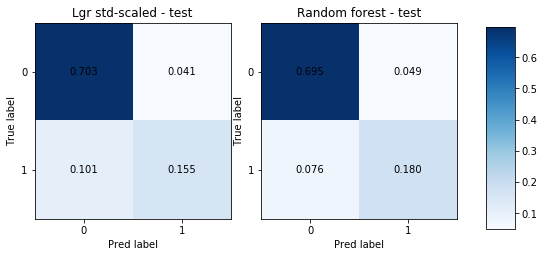

In [59]:
_  = compute_and_plot_cm(models_plus, [model + ' - train' for model in model_names_plus], X_sets_plus, y, normalize=True, format='%.3f')
_  = compute_and_plot_cm(models_plus, [model + ' - test'  for model in model_names_plus], X_test_sets_plus, y_test, normalize=True, format='%.3f')

## ROC curves

Nearly no difference in the ROC curves with/without the new features.

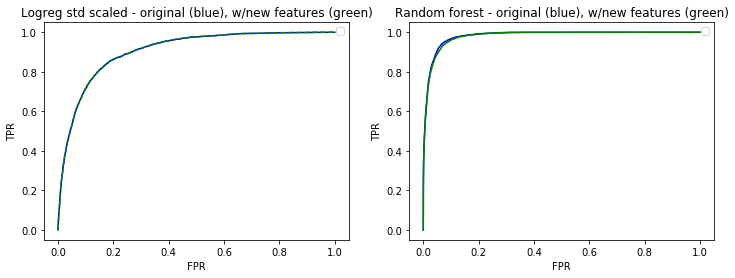

In [60]:
# note: seaborn lineplot is extremely slow, so better use matplotlib.pyplot.plot

fig, axs = plt.subplots(1, 2, figsize=(12,4))

_,_,_ = compute_and_plot_rocs([models[0]],      [X_sets[0]],      y, ['blue'],  ['solid'], axs[0], legend='', title='')
_,_,_ = compute_and_plot_rocs([models_plus[0]], [X_sets_plus[0]], y, ['green'], ['dashed'], axs[0], legend='', title='Logreg std scaled - original (blue), w/new features (green)')

_,_,_ = compute_and_plot_rocs([models[2]],      [X_sets[2]],      y, ['blue'],  ['solid'], axs[1], legend='', title='')
_,_,_ = compute_and_plot_rocs([models_plus[1]], [X_sets_plus[1]], y, ['green'], ['solid'], axs[1], legend='', title='Random forest - original (blue), w/new features (green)')

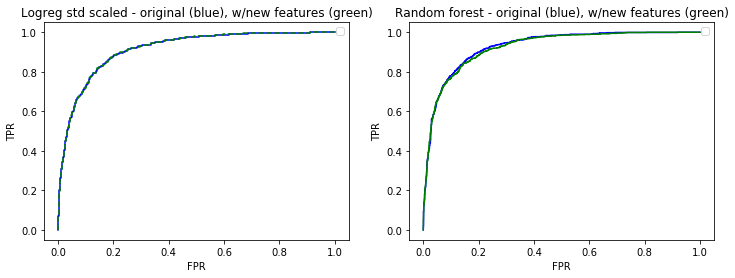

In [61]:
# note: seaborn lineplot is extremely slow, so better use matplotlib.pyplot.plot

fig, axs = plt.subplots(1, 2, figsize=(12,4))

_,_,_ = compute_and_plot_rocs([models[0]],      [X_test_sets[0]],      y_test, ['blue'],  ['solid'],  axs[0], legend='', title='')
_,_,_ = compute_and_plot_rocs([models_plus[0]], [X_test_sets_plus[0]], y_test, ['green'], ['dashed'], axs[0], legend='', title='Logreg std scaled - original (blue), w/new features (green)')

_,_,_ = compute_and_plot_rocs([models[2]],      [X_test_sets[2]],      y_test, ['blue'],  ['solid'], axs[1], legend='', title='')
_,_,_ = compute_and_plot_rocs([models_plus[1]], [X_test_sets_plus[1]], y_test, ['green'], ['solid'], axs[1], legend='', title='Random forest - original (blue), w/new features (green)')

## Quantile evaluation

* Small improvement of the logreg model in the lift & precision of the 10th decile of the test set by adding the new features.
* Small decaly in the performance of the random forest when classifying the 10th decile of the test set with the new features.

In [62]:
%%time
percentile_metrics_plus = {}
decile_metrics_plus = {}

for idx, (model, X) in enumerate(zip(models_plus,X_sets_plus)):
    y_prob = model.best_estimator_.predict_proba(X)[:,1]
    percentile_metrics_plus[idx] = quantile_metrics(y_true = y, y_prob=y_prob, quantile_idxs=percentiles)
    decile_metrics_plus[idx]     = quantile_metrics(y_true = y, y_prob=y_prob, quantile_idxs=deciles)

Wall time: 1.06 s


In [63]:
%%time
test_percentile_metrics_plus = {}
test_decile_metrics_plus = {}

for idx, (model, X) in enumerate(zip(models_plus,X_test_sets_plus)):
    y_prob = model.best_estimator_.predict_proba(X)[:,1]
    test_percentile_metrics_plus[idx] = quantile_metrics(y_true = y_test, y_prob=y_prob, quantile_idxs=test_percentiles)
    test_decile_metrics_plus[idx]     = quantile_metrics(y_true = y_test, y_prob=y_prob, quantile_idxs=test_deciles)

Wall time: 233 ms


In [64]:
compare_model_quantile_metrics(percentile_metrics_plus, model_names_plus, 1)

,quantile,n,tp,lift,precision,max_lift
Lgr std-scaled,100.0,315,292,3.621930,0.926984,3.907219
Random forest,100.0,315,315,3.907219,1.000000,3.907219


In [65]:
compare_model_quantile_metrics(percentile_metrics, model_names, 1)

,quantile,n,tp,lift,precision,max_lift
Lgr std-scaled,100.0,315,292,3.621930,0.926984,3.907219
Lgr minmax-scaled,100.0,315,292,3.621930,0.926984,3.907219
Random forest,100.0,315,315,3.907219,1.000000,3.907219


In [66]:
compare_model_quantile_metrics(decile_metrics_plus, model_names_plus, 1)

,quantile,n,tp,lift,precision,max_lift
Lgr std-scaled,10.0,3150,2686,3.331679,0.852698,3.907219
Random forest,10.0,3150,3103,3.848921,0.985079,3.907219


In [67]:
compare_model_quantile_metrics(decile_metrics, model_names, 1)

,quantile,n,tp,lift,precision,max_lift
Lgr std-scaled,10.0,3150,2683,3.327958,0.851746,3.907219
Lgr minmax-scaled,10.0,3150,2685,3.330439,0.852381,3.907219
Random forest,10.0,3150,3106,3.852642,0.986032,3.907219


In [68]:
compare_model_quantile_metrics(test_decile_metrics_plus, model_names_plus, 1)

,quantile,n,tp,lift,precision,max_lift
Lgr std-scaled,10.0,350,309,3.448661,0.882857,3.90625
Random forest,10.0,350,311,3.470982,0.888571,3.90625


In [69]:
compare_model_quantile_metrics(test_decile_metrics, model_names, 1)

,quantile,n,tp,lift,precision,max_lift
Lgr std-scaled,10.0,350,308,3.437500,0.880000,3.90625
Lgr minmax-scaled,10.0,350,309,3.448661,0.882857,3.90625
Random forest,10.0,350,313,3.493304,0.894286,3.90625


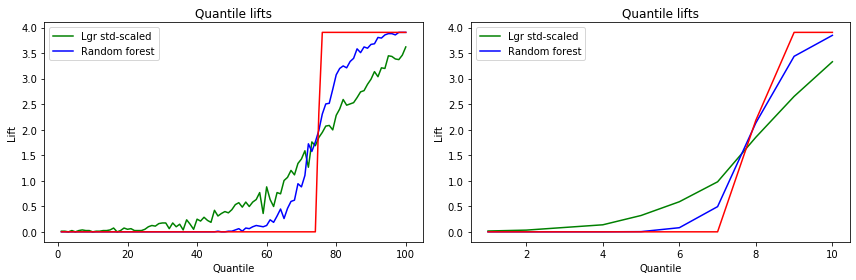

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
lift_plotting(percentile_metrics_plus, ['green', 'blue'], ['solid', 'solid'], model_names_plus, axs[0])
lift_plotting(decile_metrics_plus,     ['green', 'blue'], ['solid', 'solid'], model_names_plus, axs[1])

plt.tight_layout()

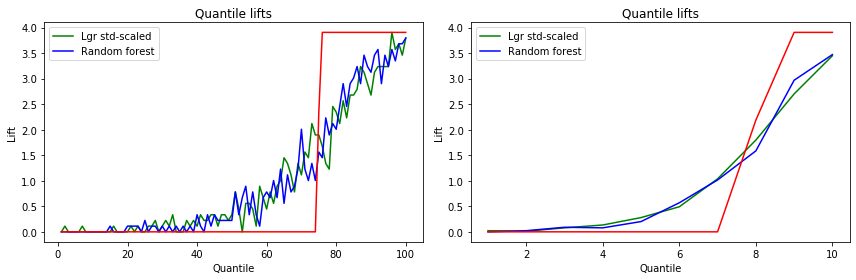

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
lift_plotting(test_percentile_metrics_plus, ['green', 'blue'], ['solid', 'solid'], model_names_plus, axs[0])
lift_plotting(test_decile_metrics_plus,     ['green', 'blue'], ['solid', 'solid'], model_names_plus, axs[1])

plt.tight_layout()

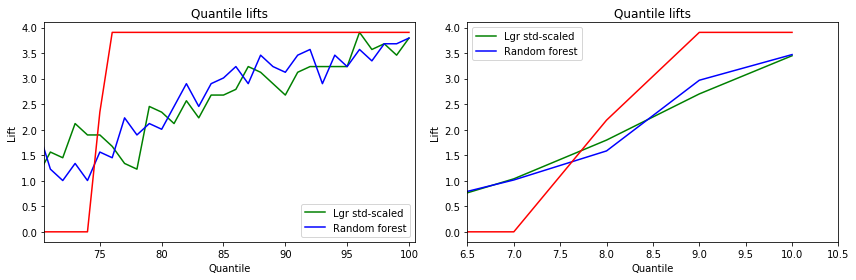

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
lift_plotting(test_percentile_metrics_plus, ['green', 'blue'], ['solid', 'solid'], model_names_plus, axs[0])
lift_plotting(test_decile_metrics_plus,     ['green', 'blue'], ['solid', 'solid'], model_names_plus, axs[1])

axs[0].set_xlim([70.5, 100.5])
axs[1].set_xlim([6.5, 10.5])
plt.tight_layout()

# Undersampling

* The original dataset has about 26% of records with positive target (is_payer).
* Here, we'll try undersampling the non-paying class to get 50%-50% positives and negatives in the training set.

In [73]:
pd.concat([pd.value_counts(y), pd.value_counts(y, normalize=True)], axis=1)

,is_payer,is_payer
0,23437,0.744055
1,8062,0.255945


In [74]:
non_paying_indices = X_enc[y == 0].index

np.random.seed(1234)
random_indices = np.random.choice(non_paying_indices,len(X_enc[y==1]), replace=False)

In [75]:
X_enc_usampled = pd.concat([X_enc.loc[random_indices, :], X_enc[y==1]])
X_enc_scaled_usampled = StandardScaler().fit_transform(X_enc_usampled)
y_usampled = pd.concat([y[random_indices], y[y==1] ])

In [76]:
pd.concat([pd.value_counts(y_usampled), pd.value_counts(y_usampled, normalize=True)], axis=1)

,is_payer,is_payer
1,8062,0.5
0,8062,0.5


In [77]:
X_sets_usampled = [X_enc_scaled_usampled, X_enc_usampled]

## Training

In [78]:
%%time
lgrParams = {'C': list(np.arange(0.1, 10.0, 0.1)), 'penalty': ['l1', 'l2']}

# Standard scaling
gridSearchLgr_usampled = GridSearchCV(estimator=LogisticRegression(solver='liblinear'), cv=3,
                             param_grid=lgrParams,scoring='roc_auc').fit(X_enc_scaled_usampled, y_usampled)

Wall time: 1min 11s


In [79]:
%%time
rfParams = {'max_depth': list(np.arange(5, 25, 1)), 'n_estimators': list(np.arange(20, 250, 10))}
RandSearchRF_usampled = RandomizedSearchCV(estimator=RandomForestClassifier(), cv=3, 
                             param_distributions=rfParams, scoring='roc_auc').fit(X_enc_usampled, y_usampled)

Wall time: 37 s


In [80]:
print('%10s' % 'C: ',      gridSearchLgr_usampled.best_estimator_.C)
print('%10s' % 'Penalty:', gridSearchLgr_usampled.best_estimator_.penalty)

       C:  9.1
  Penalty: l1


In [81]:
print('%10s' % 'Max_depth: ', RandSearchRF_usampled.best_estimator_.max_depth)
print('%10s' % 'Estimators:', RandSearchRF_usampled.best_estimator_.n_estimators)

Max_depth:  11
Estimators: 60


In [82]:
models_usampled = [gridSearchLgr_usampled, RandSearchRF_usampled]
model_names_usampled = model_names_plus

## AUC values

* Just like for adding features, training with an undersampled dataset also makes the models' performance decay, contrary to what was intended. 
* The decay is observed for both training and test sets.

In [83]:
print('Training set AUCs with new features:')
plot_model_aucs(models_usampled, model_names_usampled, X_sets_usampled, y_usampled, num_format='%.3f')

print('')

print('Training set AUCs with original features:')
plot_model_aucs(models, model_names, X_sets, y, num_format='%.3f')

Training set AUCs with new features:
      Lgr std-scaled 0.835
       Random forest 0.913

Training set AUCs with original features:
      Lgr std-scaled 0.850
   Lgr minmax-scaled 0.850
       Random forest 0.937


In [84]:
print('Test set AUCs:')
plot_model_aucs(models_usampled, model_names_usampled, X_test_sets, y_test, num_format='%.3f')

print('')

print('Training set AUCs with original features:')
plot_model_aucs(models, model_names, X_test_sets, y_test, num_format='%.3f')

Test set AUCs:
      Lgr std-scaled 0.767
       Random forest 0.744

Training set AUCs with original features:
      Lgr std-scaled 0.856
   Lgr minmax-scaled 0.856
       Random forest 0.877


## Confusion matrix

* Both logreg and random forest models now have way more false positives. 
* This should that both models now have much more propension to classify a record as a positve what may be a result of the increased representativity of the positive class in the training set.

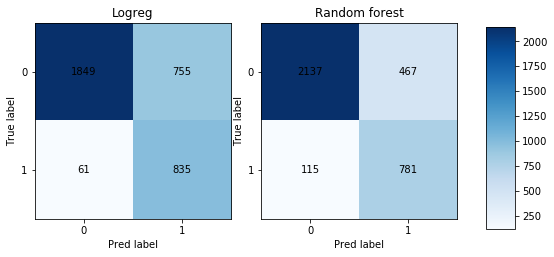

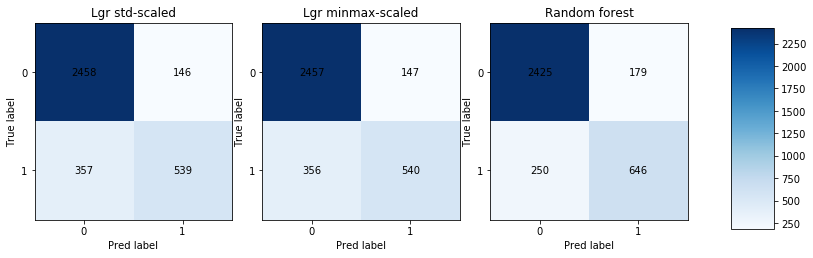

In [85]:
cm_plus = compute_and_plot_cm(models_usampled, ['Logreg','Random forest'], [X_test_sets[0], X_test_sets[2]], y_test, normalize=False, format='%d')
_       = compute_and_plot_cm(models,          model_names,                X_test_sets, y_test, normalize=False, format='%d')

## ROC curves

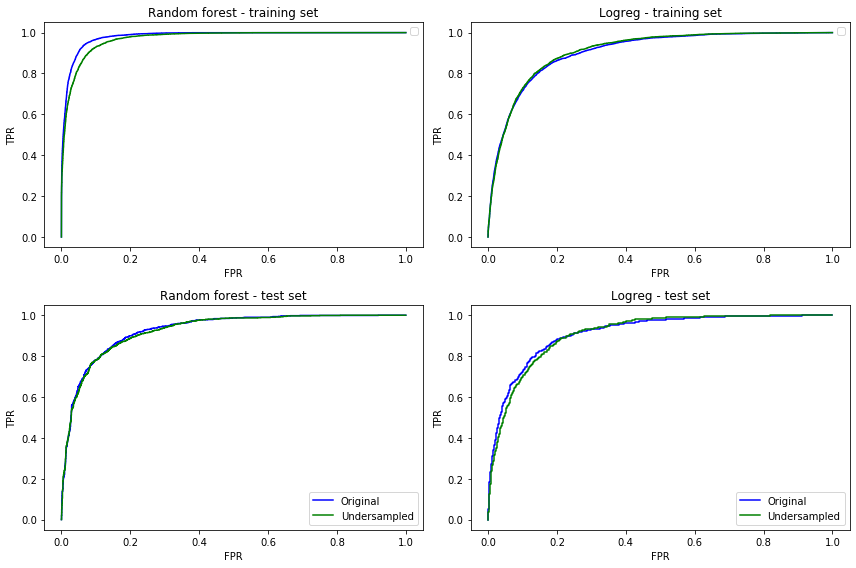

In [86]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))
_,_,_=compute_and_plot_rocs([models[2]],          [X_sets[2]],          y,          ['blue'], linestyles, axs[0,0], legend='', title='Random forest - training set')
_,_,_=compute_and_plot_rocs([models_usampled[1]], [X_sets_usampled[1]], y_usampled, ['green'], linestyles, axs[0,0], legend='', title='Random forest - training set')

_,_,_=compute_and_plot_rocs([models[0]],          [X_sets[0]],          y,          ['blue'], linestyles, axs[0,1], legend='', title='Logreg - training set')
_,_,_=compute_and_plot_rocs([models_usampled[0]], [X_sets_usampled[0]], y_usampled, ['green'], linestyles, axs[0,1], legend='', title='Logreg - training set')

_,_,_=compute_and_plot_rocs([models[2], models_usampled[1]], [X_test_sets[2], X_test_sets[2]], y_test, ['blue', 'green'], ['solid']*2, axs[1,0], legend=['Original', 'Undersampled'], title='Random forest - test set')
_,_,_=compute_and_plot_rocs([models[0], models_usampled[0]], [X_test_sets[0], X_test_sets[0]], y_test, ['blue', 'green'], ['solid']*2, axs[1,1], legend=['Original', 'Undersampled'], title='Logreg - test set')

plt.tight_layout()

## Quantile eval

In [87]:
percentiles_usampled = index_for_percentiles(array_length = len(X_enc_usampled), num_splits = 100)
deciles_usampled     = index_for_percentiles(array_length = len(X_enc_usampled), num_splits = 10)

In [88]:
X_sets_usampled = [X_enc_scaled_usampled, X_enc_usampled]

In [89]:
%%time
percentile_metrics_usampled = {}
decile_metrics_usampled = {}

for idx, (model, X) in enumerate(zip(models_usampled,X_sets_usampled)):
    y_prob = model.best_estimator_.predict_proba(X)[:,1]
    percentile_metrics_usampled[idx] = quantile_metrics(y_true = y_usampled, y_prob=y_prob, quantile_idxs=percentiles_usampled)
    decile_metrics_usampled[idx]     = quantile_metrics(y_true = y_usampled, y_prob=y_prob, quantile_idxs=deciles_usampled)

Wall time: 307 ms


In [90]:
%%time
test_percentile_metrics_usampled = {}
test_decile_metrics_usampled = {}

for idx, (model, X) in enumerate(zip(models_usampled,[X_test_sets[0], X_test_sets[2]])):
    y_prob = model.best_estimator_.predict_proba(X)[:,1]
    test_percentile_metrics_usampled[idx] = quantile_metrics(y_true = y_test, y_prob=y_prob, quantile_idxs=test_percentiles)
    test_decile_metrics_usampled[idx]     = quantile_metrics(y_true = y_test, y_prob=y_prob, quantile_idxs=test_deciles)

Wall time: 122 ms


In [91]:
compare_model_quantile_metrics(percentile_metrics_usampled, model_names_usampled, 1)

,quantile,n,tp,lift,precision,max_lift
Lgr std-scaled,100.0,162,160,1.984619,0.987654,2.009427
Random forest,100.0,162,162,2.009427,1.000000,2.009427


In [92]:
compare_model_quantile_metrics(percentile_metrics, model_names, 1)

,quantile,n,tp,lift,precision,max_lift
Lgr std-scaled,100.0,315,292,3.621930,0.926984,3.907219
Lgr minmax-scaled,100.0,315,292,3.621930,0.926984,3.907219
Random forest,100.0,315,315,3.907219,1.000000,3.907219


In [106]:
compare_model_quantile_metrics(decile_metrics_usampled, model_names_usampled, 1)

,quantile,n,tp,lift,precision,max_lift
Lgr std-scaled,10.0,1613,1539,1.908956,0.954123,2.000744
Random forest,10.0,1613,1612,1.999504,0.999380,2.000744


In [107]:
compare_model_quantile_metrics(decile_metrics, model_names, 1)

,quantile,n,tp,lift,precision,max_lift
Lgr std-scaled,10.0,3150,2683,3.327958,0.851746,3.907219
Lgr minmax-scaled,10.0,3150,2685,3.330439,0.852381,3.907219
Random forest,10.0,3150,3106,3.852642,0.986032,3.907219


In [105]:
compare_model_quantile_metrics(test_decile_metrics_usampled, model_names_usampled, 1)

,quantile,n,tp,lift,precision,max_lift
Lgr std-scaled,10.0,350,296,3.303571,0.845714,3.90625
Random forest,10.0,350,314,3.504464,0.897143,3.90625


In [104]:
compare_model_quantile_metrics(test_decile_metrics, model_names, 1)

,quantile,n,tp,lift,precision,max_lift
Lgr std-scaled,10.0,350,308,3.437500,0.880000,3.90625
Lgr minmax-scaled,10.0,350,309,3.448661,0.882857,3.90625
Random forest,10.0,350,313,3.493304,0.894286,3.90625


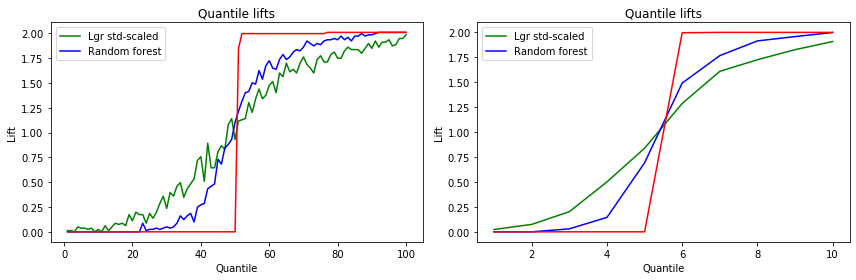

In [95]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
lift_plotting(percentile_metrics_usampled, ['green', 'blue'], ['solid', 'solid'], model_names_usampled, axs[0])
lift_plotting(decile_metrics_usampled,     ['green', 'blue'], ['solid', 'solid'], model_names_usampled, axs[1])

plt.tight_layout()

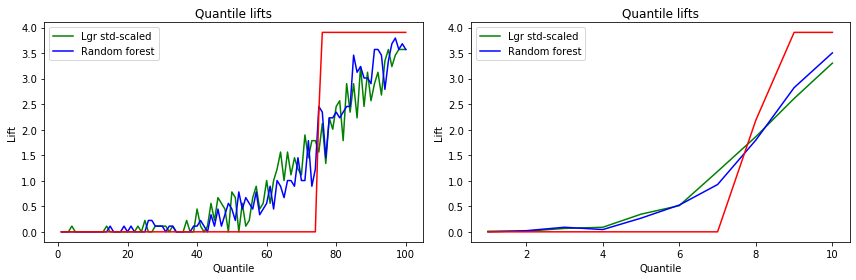

In [96]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
lift_plotting(test_percentile_metrics_usampled, ['green', 'blue'], ['solid', 'solid'], model_names_usampled, axs[0])
lift_plotting(test_decile_metrics_usampled,     ['green', 'blue'], ['solid', 'solid'], model_names_usampled, axs[1])

plt.tight_layout()

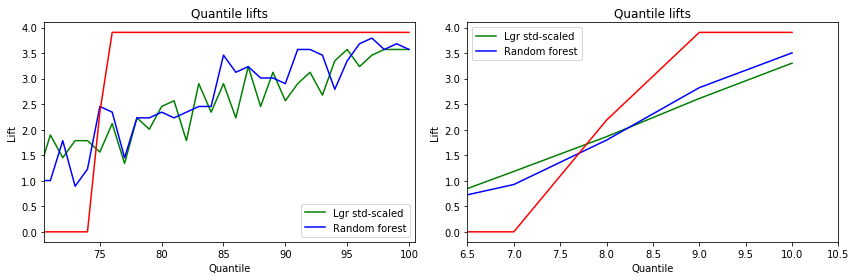

In [97]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
lift_plotting(test_percentile_metrics_usampled, ['green', 'blue'], ['solid', 'solid'], model_names_usampled, axs[0])
lift_plotting(test_decile_metrics_usampled,     ['green', 'blue'], ['solid', 'solid'], model_names_usampled, axs[1])

axs[0].set_xlim([70.5, 100.5])
axs[1].set_xlim([6.5, 10.5])
plt.tight_layout()

# Feature importance

* The newly created features figure in the top 6 of importance.
* The weight of the player_level compared to the 2nd most important feature is:
    + 27% higher in the original model.
    + 53% higher in the model with added features.
    + 95% higher in the model trained on undersampled data.

In [98]:
%%time
# Retrain with all dataset
RF_original = RandomForestClassifier(max_depth=13, n_estimators=165).fit(X_enc, y)
RF_plus     = RandomForestClassifier(max_depth=12, n_estimators=165).fit(X_enc_plus, y)
RF_usampled = RandomForestClassifier(max_depth=11, n_estimators=60).fit(X_enc_usampled, y_usampled)

Wall time: 15 s


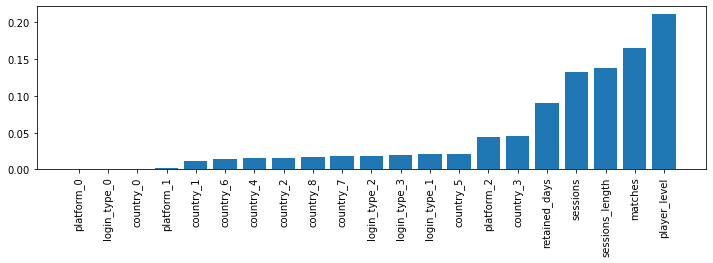

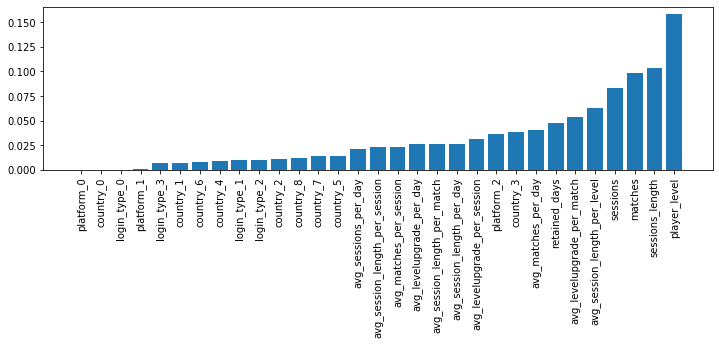

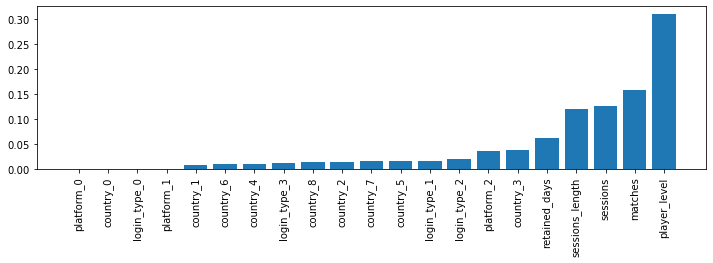

In [99]:
for model, X in zip([RF_original, RF_plus, RF_usampled], [X_enc, X_enc_plus, X_enc_usampled]):
    plt.figure(figsize=(12, 3))
    importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_}).sort_values(by='Importance')
    plt.bar(importances.Feature, importances.Importance)
    plt.xticks(rotation='vertical')
    plt.show()

In [100]:
for model, X in zip([RF_original, RF_plus, RF_usampled], [X_enc, X_enc_plus, X_enc_usampled]):

    print(pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_}).sort_values(by='Importance').tail(2))

         Feature  Importance
19       matches    0.165436
20  player_level    0.211145
            Feature  Importance
12  sessions_length    0.103314
20     player_level    0.158121
         Feature  Importance
19       matches    0.158621
20  player_level    0.309053


In [101]:
21/16.5

1.2727272727272727

In [102]:
15.8/10.3

1.5339805825242718

In [103]:
30.9/15.8

1.9556962025316453